# Implement a classical Vision Transformer
Link of Colab Notebook: https://colab.research.google.com/drive/1wQlb-oKgFwOUkShoAHlRApINlKCwriOJ

In [ ]:
! pip install -q tensorflow==2.8.3

Tensorflow 2.8.3 is being used to avoid some warning that are generated because of the following bug in TF- https://github.com/tensorflow/tensorflow/issues/56242

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [ ]:
tf.__version__

'2.8.3'

## Data Preparation

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}\n")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (60000, 28, 28)
y_train shape: (60000,)

x_test shape: (10000, 28, 28)
y_test shape: (10000,)


In [ ]:
image_size = x_train.shape[1]
input_size = 28

In [ ]:
x_train = np.array(x_train).reshape((-1, input_size, input_size, 1))
x_test = np.array(x_test).reshape((-1, input_size, input_size, 1))

print(f"x_train shape: {x_train.shape}")
print(f"x_test shape: {x_test.shape}")

x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)


In [ ]:
data_augmentation = keras.Sequential(
    [
        keras.layers.Normalization(),
        keras.layers.Resizing(image_size, image_size),
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(factor=0.02),
        keras.layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

## Vision Transformer

The Vision Transformer (ViT) model architecture was introduced in a research paper published as a conference paper at ICLR 2021 titled “An Image is Worth 16*16 Words: Transformers for Image Recognition at Scale”. It was developed and published by Neil Houlsby, Alexey Dosovitskiy, and 10 more authors of the Google Research Brain Team. Here is the architecture of the porposed model-

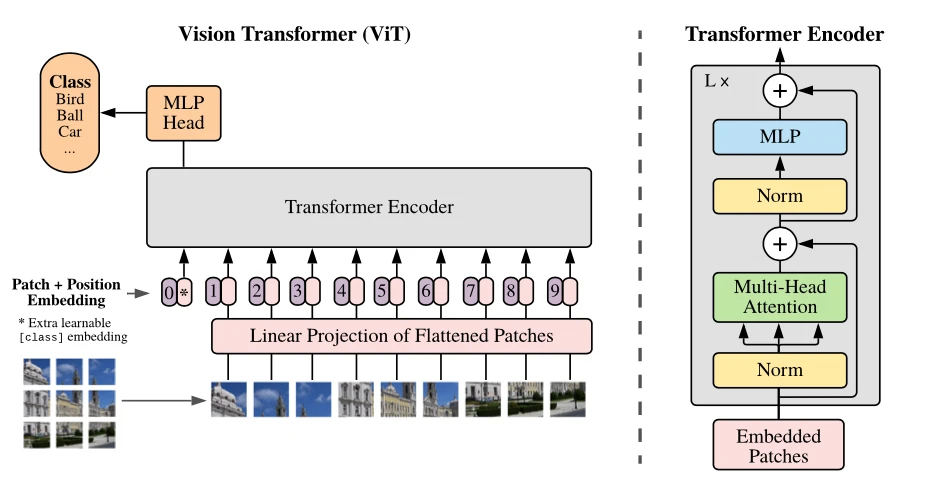

The overall structure of the vision transformer architecture consists of the following steps: 

- Split an image into patches (fixed sizes)
- Flatten the image patches
- Create lower-dimensional linear embeddings from these flattened image patches
- Include positional embeddings
- Feed the sequence as an input to a state-of-the-art transformer encoder
- Pre-train the ViT model with image labels, which is then fully supervised on a big dataset
- Fine-tune the downstream dataset for image classification

Here is a simplified architecture -

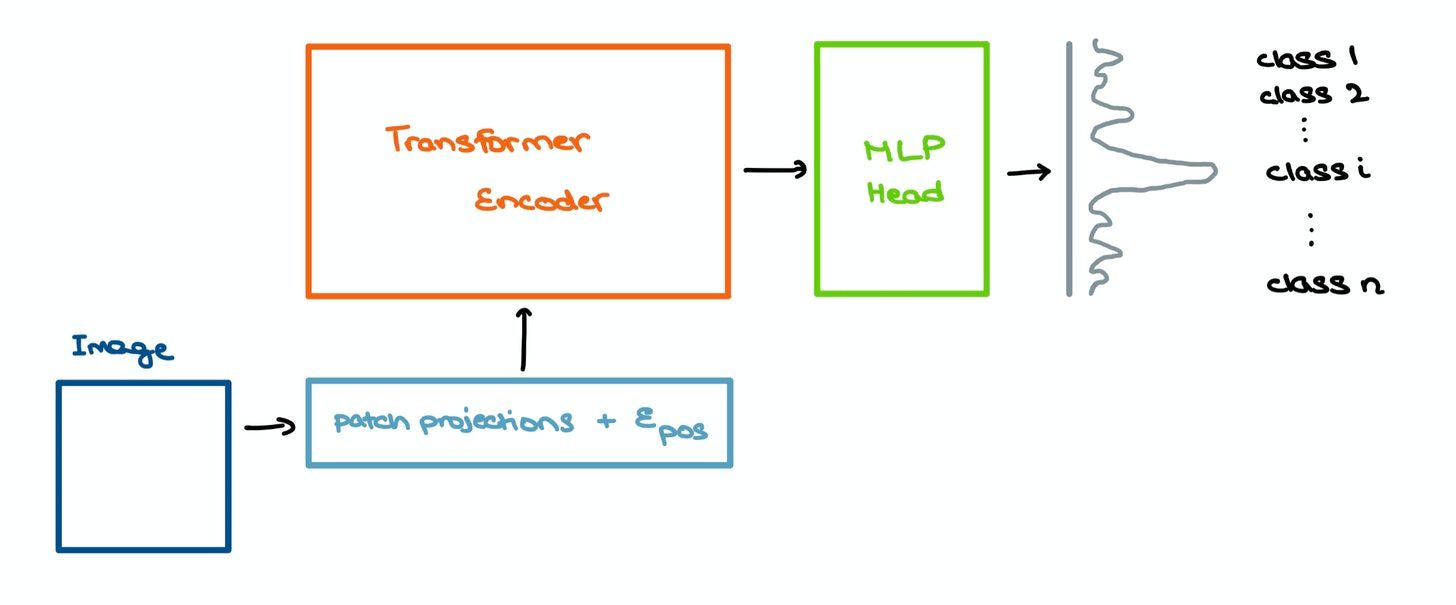


### Patch generation + Embedding

In [ ]:
class Patches(keras.layers.Layer):
    """" divides an image into fixed-size patches."""
    def __init__(self, patch_size):
        """
          Args:
              patch_size (int): size of patches
        """
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [ ]:
class PatchEncoder(keras.layers.Layer):
    '''
    linearly transforms a patch by projecting it into a vector of size projection_dim and
    adds a learnable position embedding to the projected vector.
    '''
    def __init__(self, num_patches, projection_dim):
        '''
        Args:
              num_patches (int): number of pathces for each image (image_size // patch_size) ** 2)
              projection_dim (int) : dimntion of optput
        '''
        super().__init__()
        self.num_patches = num_patches
        self.projection = keras.layers.Dense(units=projection_dim)
        self.position_embedding = keras.layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


### MLP

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    ''''
    a two-layer classification network with GELU  activation that outputs the features which can be later used for classification
    
    Args:
      x (tensor) : output of transformers after normalization & flattening
      hidden_units (list) : Size of the dense layers of the final classifier
      dropout_rate (int) : dropout rate
    '''
    for units in hidden_units:
        x = keras.layers.Dense(units, activation=tf.nn.gelu)(x)
        x = keras.layers.Dropout(dropout_rate)(x)
    return x

### Parameters

In [ ]:
input_shape = [28,28,1]
patch_size = 6
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
transformer_layers = 8
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]

mlp_head_units = [2048, 1024] 

num_classes = 10

### Building ViT

Here I have used TensorFlow's buit-in LayerNormalization & MultiHeadAttention layers

In [ ]:
def build_vit_classifier():
    ''' Builds the ViT classifier model '''

    inputs = keras.layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = keras.layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = keras.layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = keras.layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = keras.layers.Flatten()(representation)
    representation = keras.layers.Dropout(0.5)(representation)

    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = keras.layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

## Experiment

In [ ]:
batch_size = 256
num_epochs = 1
learning_rate = 0.001
weight_decay = 0.0001


In [ ]:
def run_experiment(model):
    optimizer = tf.keras.optimizers.Adam(
        lr=learning_rate, decay=weight_decay) # use learning_rate & weight_decay instead of lr & decay for versions >2.11

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = build_vit_classifier()
history = run_experiment(vit_classifier)

(None, 1024)


/usr/local/lib/python3.9/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


313/313 [==============================] - 23s 75ms/step - loss: 0.1711 - accuracy: 0.9461 - top-5-accuracy: 0.9980
Test accuracy: 94.61%
Test top 5 accuracy: 99.8%


### Quantum Vision Transformer

An architechture for Quantum Vision Transformer has been proposed here - https://github.com/shoaib6174/QMLHEP-tasks-2023/blob/main/QMLHEP%20Task%20VIII_%20Quantum%20ViT.pdf